In [47]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import joblib

In [33]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
df = pd.read_csv("data.csv")
df.shape

(3999, 2)

In [50]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.shape
joblib.dump(df,'dataframe.pkl')

['dataframe.pkl']

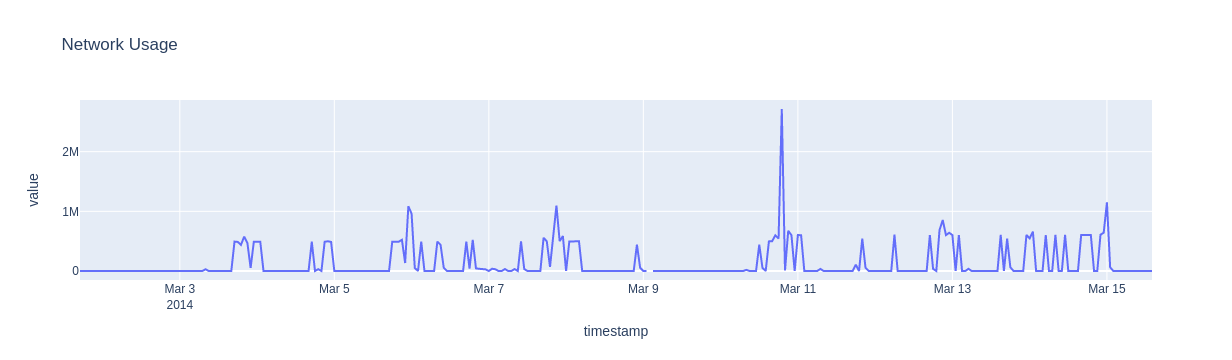

In [35]:
#express to plot entire data
fig = px.line(df.reset_index(), x='timestamp', y='value', title='Network Usage')
fig.show()

In [36]:
from fbprophet import Prophet
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [38]:
#train test split
train, test = train_test_split(taxi_df, test_size=0.2, shuffle=False)
print("Number of training samples: ",len(train))
print("Number of testing sample: ",len(test))


Number of training samples:  267
Number of testing sample:  67


In [39]:
m = Prophet(changepoint_range=0.95)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -3.53403


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       502.528   8.04792e-05       70.2172      0.9937      0.9937      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       502.545   1.18472e-05       82.8404   1.725e-07       0.001      263  LS failed, Hessian reset 
     189       502.545   3.56877e-08       60.0946      0.7445      0.7445      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [40]:
future = m.make_future_dataframe(periods=119, freq='H')
future.tail(4)


,ds
382,2014-03-17 15:00:00
383,2014-03-17 16:00:00
384,2014-03-17 17:00:00
385,2014-03-17 18:00:00


In [41]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
381,2014-03-17 14:00:00,21321.283121,-301547.308370,344150.961279
382,2014-03-17 15:00:00,57978.853404,-253651.244421,375394.889215
383,2014-03-17 16:00:00,132496.858414,-167884.111892,422765.266977
384,2014-03-17 17:00:00,219160.017769,-95137.937273,540628.004951
385,2014-03-17 18:00:00,284891.024326,-33984.451195,604574.342614


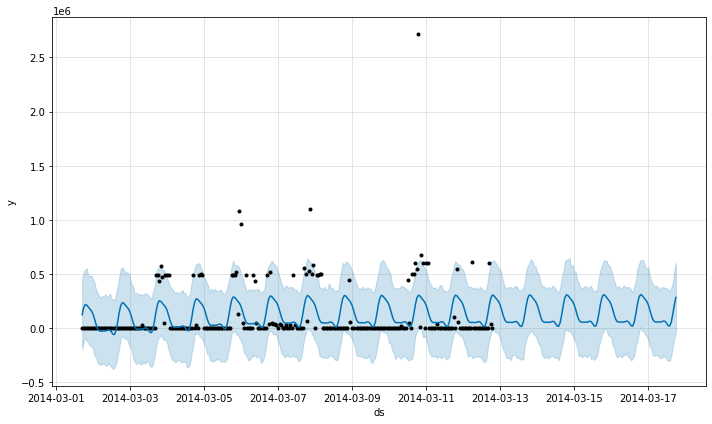

In [42]:
result = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

In [43]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [44]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

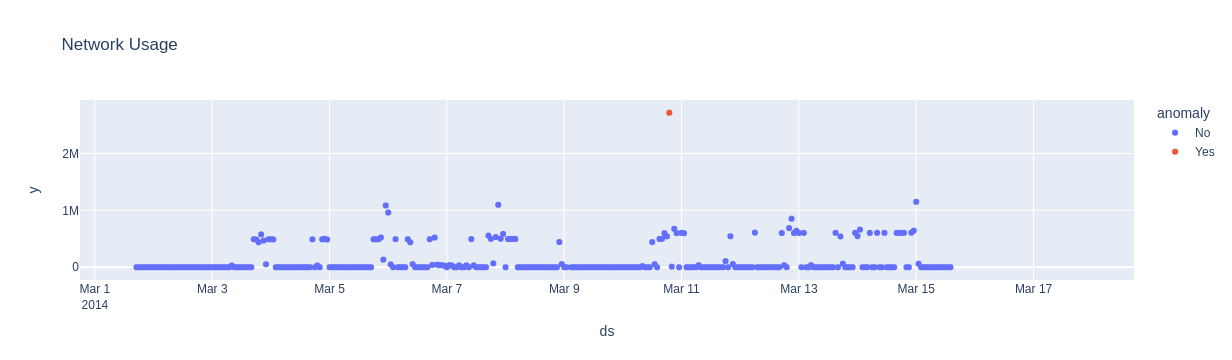

In [45]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Network Usage')
fig.show()